# Forcasting model for Covid-19 data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets

from sklearn import metrics
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LassoLars
from sklearn.linear_model import LassoLars

from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from scipy.special import softmax

# don't raise 'SettingWithCopyWarning'
pd.set_option('mode.chained_assignment', None)

# Reading Covid dataset

The analysis will be based on the Covid-19 data provided by [Our World in Data](https://github.com/owid).

In [2]:
data_url = (
    "https://raw.githubusercontent.com/"
    "owid/covid-19-data/master/public/data/owid-covid-data.csv"
)
raw_df = pd.read_csv(data_url)
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67166 entries, 0 to 67165
Data columns (total 59 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   iso_code                               64184 non-null  object 
 1   continent                              63802 non-null  object 
 2   location                               67166 non-null  object 
 3   date                                   67166 non-null  object 
 4   total_cases                            66555 non-null  float64
 5   new_cases                              66553 non-null  float64
 6   new_cases_smoothed                     65552 non-null  float64
 7   total_deaths                           57718 non-null  float64
 8   new_deaths                             57876 non-null  float64
 9   new_deaths_smoothed                    65552 non-null  float64
 10  total_cases_per_million                63578 non-null  float64
 11  ne

Pre-processing dataset:

- Renormalize date to a `datetime` object.
- Reduce the number of columns
- Set date as index
- Drop `NaN`'s
- Fix types for columns

In [3]:
total_df = raw_df.copy()
total_df.date = pd.to_datetime(total_df.date)
total_df = total_df[
    [
        "location",
        "date",
        "total_cases",
        "new_cases",
        "new_cases_smoothed",
        "total_deaths",
        "new_deaths",
        "new_deaths_smoothed",
        "icu_patients",
    ]
]
total_df = total_df.set_index("date")
total_df = total_df.dropna()
total_df = total_df.astype(
    {
        "total_cases": int,
        "new_cases": int,
        "total_deaths": int,
        "new_deaths": int,
        "icu_patients": int,
    }
)
total_df

,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,icu_patients
date,,,,,,,,
2020-04-01,Austria,10711,531,731.857,146,18,16.571,215
2020-04-02,Austria,11129,418,602.857,158,12,15.571,219
2020-04-03,Austria,11524,395,552.429,168,10,15.714,245
2020-04-04,Austria,11781,257,501.429,186,18,16.857,245
2020-04-05,Austria,12051,270,466.143,204,18,16.857,244
...,...,...,...,...,...,...,...,...
2021-01-31,United States,26186781,111896,148412.857,441324,1794,3153.286,18968
2021-02-01,United States,26321120,134339,146019.143,443355,2031,3169.571,18572
2021-02-02,United States,26435557,114437,141424.857,446885,3530,3090.429,18388


## Data exploration



In [4]:
@widgets.interact(
    country=total_df.location.unique(),
    column=[c for c in total_df.columns if c not in ["location", "date"]],
)
def plot_evolution(country, column):
    total_df.loc[total_df.location == country].plot(
        y=column,
        figsize=(15, 5),
        xlim=(pd.Timestamp("2020-01-01"), pd.Timestamp("2021-02-02")),
    )

interactive(children=(Dropdown(description='country', options=('Austria', 'Belgium', 'Bulgaria', 'Canada', 'Cy…

In [5]:
@widgets.interact(
    country=widgets.Dropdown(options=total_df.location.unique()),
)
def compare_newCases_icu_deaths(country):
    (total_df
        .loc[total_df.location == country]
        .apply(lambda x: x / x.max() if x.name in {"new_cases_smoothed", "new_deaths_smoothed", "icu_patients"} else x)
        .plot(
            y=["new_cases_smoothed","icu_patients", "new_deaths_smoothed"],
            figsize=(15, 5),
            xlim=(pd.Timestamp("2020-01-01"), pd.Timestamp("2021-02-02")),
        )
    )

interactive(children=(Dropdown(description='country', options=('Austria', 'Belgium', 'Bulgaria', 'Canada', 'Cy…

## Model description

```
+-----------+     +---------------+     +--------+
| New cases | ==> | New ICU cases | ==> | Deaths |
+-----------+     +---------------+     +--------+
```

In the following we want to develop a model to forecast the number of ICU's based on the number of new cases. We can clearly say that a fraction of new cases, will end up needing intensive care. However, we also know that there is a fraction of patients being released. 

We start by examining which model we should use even before looking at feature engineering. Our intuition suggests to use a linear regression model.

In [6]:
icu_patients = total_df.loc[total_df.location == "Germany"][["icu_patients", "new_cases", "new_cases_smoothed"]]
icu_patients["icu_patients_yesterday"] = icu_patients["icu_patients"].shift(1)
icu_patients = icu_patients.dropna()
icu_patients

,icu_patients,new_cases,new_cases_smoothed,icu_patients_yesterday
date,,,,
2020-03-21,308,2365,2518.286,200.0
2020-03-22,364,2660,2725.429,308.0
2020-03-23,451,4183,3112.000,364.0
2020-03-24,616,3930,3389.857,451.0
2020-03-25,789,4337,3570.857,616.0
...,...,...,...,...
2021-01-27,4487,15636,11294.429,4559.0
2021-01-28,4428,14883,12238.143,4487.0
2021-01-29,4367,12831,11733.143,4428.0


### Defining training and test sets

In [7]:
X_train = icu_patients[:"2021"].drop(["icu_patients"], axis=1)
y_train = icu_patients.loc[:"2021", "icu_patients"]

X_test = icu_patients["2021"].drop(["icu_patients"], axis=1)
y_test = icu_patients.loc["2021":, "icu_patients"]

### Validate models

 LR:        -1.52 (6.34)
 NN:        -8.92 (25.60)
 RF:        -1.97 (5.62)


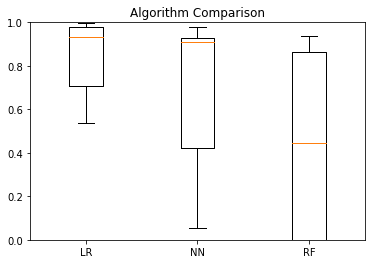

In [30]:
models = [
    ("LR", LinearRegression()),
    ("NN", MLPRegressor()),
    ("RF", RandomForestRegressor()),
]

results = []
names = []

for name, model in models:
    tscv = TimeSeriesSplit(n_splits=8)
    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring="r2")
    results.append(cv_results)
    names.append(name)
    print(f"{name:>3}: {cv_results.mean():12.2f} ({cv_results.std():.2f})")

plt.boxplot(results, labels=names)
plt.ylim((0, 1))
plt.title('Algorithm Comparison')
plt.show()

Comparing the different algorithms, we see that the assumption that linear regression might be okay holds true. For the cross-validation, we used 8 splits which comes from the number of months available in the dataset.

We can now look how the prediction for the data of 2021 going to look like for the models.

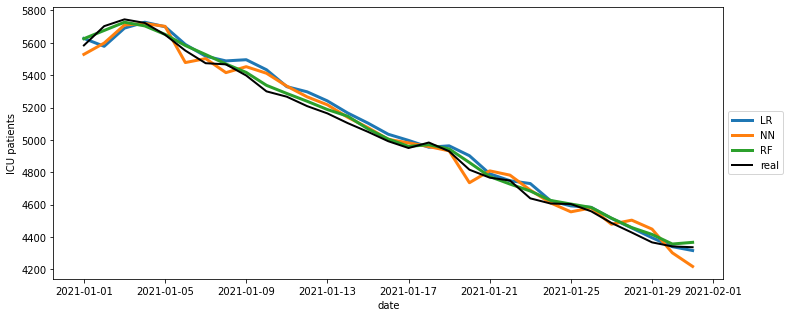

In [31]:
plt.figure(figsize=(12, 5))
for name, model in models:
    plt.plot(X_test.index, model.fit(X_train, y_train).predict(X_test), label=name, linewidth=3.0)
plt.plot(y_test, color="k", label="real", linewidth=2.0)
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.xlabel("date")
plt.ylabel("ICU patients");

We can see that the different models predict more or less the same outcome for 2021 if we train on the data for 2020. Nevertheless, we going to use linear regression and examine which feature we need for the best performance.

### Feature engineering

In [66]:
def method_1(df):
    """1: new cases"""
    return df[["icu_patients", "new_cases"]]

def method_2(df):
    """2: new cases + smoothed"""
    return df[["icu_patients", "new_cases", "new_cases_smoothed"]]

def method_3(df):
    """3: new cases + smoothed + ICU (-1d)"""
    df = df[["icu_patients", "new_cases", "new_cases_smoothed"]]
    df["icu_-1d"] = df["icu_patients"].shift(1)
    df = df.dropna()
    return df

def method_4(df):
    """4: new cases + smoothed + ICU (-1d) + ∆ICU(-1d)"""
    df = df[["icu_patients", "new_cases", "new_cases_smoothed"]]
    df["icu_-1d"] = df["icu_patients"].shift(1)
    df["icu_-1d_diff"] = df["icu_-1d"].diff()
    df = df.dropna()
    return df

def method_5(df):
    """5: new cases + smoothed new + ICU (-1d) + ∆ICU(-1d) smooth"""
    df = df[["icu_patients", "new_cases", "new_cases_smoothed"]]
    df["icu_-1d"] = df["icu_patients"].shift(1)
    df["icu_-1d_diff"] = df["icu_-1d"].diff().rolling(7, center=True).mean()
    df = df.dropna()
    return df

def method_6(df):
    """6: smoothed new + ICU(-1d) + ∆ICU(-1d)"""
    df = df[["icu_patients", "new_cases_smoothed"]]
    df["icu_-1d"] = df["icu_patients"].shift(1)
    df["icu_-1d_diff"] = df["icu_-1d"].diff().rolling(7, center=True).mean()
    df = df.dropna()
    return df

def method_7(df):
    """7: smoothed new + ICU (-1d) + ∆ICU(-1d) + ICU (-2d) + ∆ICU(-2d)"""
    df = df[["icu_patients", "new_cases_smoothed"]]
    df["icu_-1d"] = df["icu_patients"].shift(1)
    df["icu_-1d_diff"] = df["icu_-1d"].diff().rolling(7, center=True).mean()
    df["icu_-2d"] = df["icu_-1d"].shift(1)
    df["icu_-2d_diff"] = df["icu_-2d"].diff().rolling(7, center=True).mean()
    df = df.dropna()
    return df

def method_8(df):
    """8: smoothed new + new(-7d) + ICU (-1d) + ∆ICU(-1d) + ICU (-2d) + ∆ICU(-2d)"""
    df = df[["icu_patients", "new_cases_smoothed"]]
    df["new_cases_-7d"] = df["new_cases_smoothed"].shift(7)
    df["icu_-1d"] = df["icu_patients"].shift(1)
    df["icu_-1d_diff"] = df["icu_-1d"].diff().rolling(7, center=True).mean()
    df["icu_-2d"] = df["icu_-1d"].shift(1)
    df["icu_-2d_diff"] = df["icu_-2d"].diff().rolling(7, center=True).mean()
    df = df.dropna()
    return df

def method_9(df):
    """9: ICU (-1d) + ∆ICU(-1d) + ICU (-2d) + ∆ICU(-2d)"""
    df = df[["icu_patients"]]
    df["icu_-1d"] = df["icu_patients"].shift(1)
    df["icu_-1d_diff"] = df["icu_-1d"].diff().rolling(7, center=True).mean()
    df["icu_-2d"] = df["icu_-1d"].shift(1)
    df["icu_-2d_diff"] = df["icu_-2d"].diff().rolling(7, center=True).mean()
    df = df.dropna()
    return df

def prepare_training_data(df):
    X = df.loc[:"2021-01", :].drop("icu_patients", axis=1)
    y = df.loc[:"2021-01", :][["icu_patients"]]

    X_validate = df.loc["2021-01":, :].drop("icu_patients", axis=1)
    y_validate = df.loc["2021-01":, :][["icu_patients"]]

    return X, y, X_validate, y_validate

def train_model(X, y, n_splits, model):
    tscv = TimeSeriesSplit(n_splits=n_splits)

    score = []
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        score.append(model.score(X_test, y_test))

    return model, score

def model_performance_vis(df, n_splits=6, model=LinearRegression(normalize=False)):
    X, y, X_validate, y_validate = prepare_training_data(df)
    model, score = train_model(X, y, n_splits, model)

    y_validate["icu_predicted"] = model.predict(X_validate)

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 4))

    y_validate.plot.line(
        y=["icu_patients", "icu_predicted"],
        ax=ax1,
        ylabel="ICU patients",
    )
    ax1.legend(["Real", "Predicted"])
    
    feature_values = softmax(model.coef_[0])
    sorted_indices = feature_values.argsort()
    feature_names = np.array(X.columns)

    ax2.barh(np.arange(len(feature_values)), feature_values[sorted_indices], align="center")
    ax2.set_xlim(0, 1.0)
    ax2.set_xlabel("Relative importance")
    ax2.set_yticks(range(len(feature_names)))
    ax2.set_yticklabels(feature_names[sorted_indices])
    fig.tight_layout()

@widgets.interact(
    country=widgets.Dropdown(
        options=total_df.location.unique(),
        description="Country"
    ),
    method=widgets.Dropdown(
        options={v.__doc__: v for k, v in dict(globals()).items() if k.startswith("method_")},
        description="Method"
    ),
    n_splits=widgets.IntSlider(
        value=5,
        min=2,
        max=12,
        description="CV splits",
        orientation="horizontal",
    )
)
def feature_method_overview(country, method, n_splits):
    icu_patients = method(total_df[total_df.location == country])
    model_performance_vis(icu_patients, n_splits=n_splits)

interactive(children=(Dropdown(description='Country', options=('Austria', 'Belgium', 'Bulgaria', 'Canada', 'Cy…

Validate the performance of all suggested features

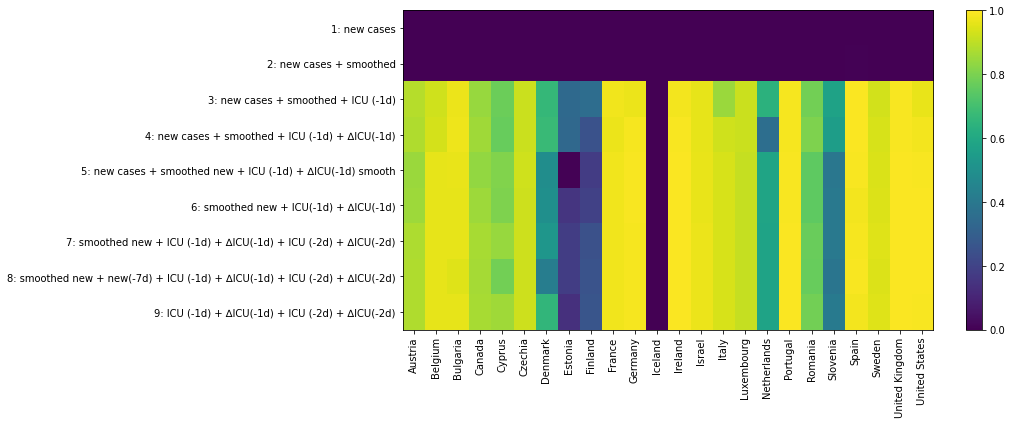

In [81]:
countries = total_df.location.unique()
feature_methods = [v for k, v in dict(globals()).items() if k.startswith("method_")]
feature_names = [v.__doc__ for k, v in dict(globals()).items() if k.startswith("method_")]
number_of_splits = 6

performance = np.zeros((len(countries), len(feature_methods)))

for i, country in enumerate(countries):
    for j, method in enumerate(feature_methods):
        df = method(total_df[total_df.location == country])
        X, y, X_validate, y_validate = prepare_training_data(df)
        model, _ = train_model(X, y, number_of_splits, LinearRegression())

        performance[i, j] = model.score(X_validate, y_validate).mean()

plt.figure(figsize=(15, 6))
plt.imshow(performance.T, aspect="auto", vmin=0.0, vmax=1.0)
plt.xticks(range(len(countries)), countries, rotation="vertical")
plt.yticks(range(len(feature_names)), feature_names)
plt.colorbar()
plt.tight_layout()

For certain countries, like Iceland, forecasting the number of ICU patients is error prone. This is due to the fact, that Iceland did not had any patients in intensive care units and our model can not capture this. However we see that we have to include the ICU's from the previous days to properly forecast the number of ICU's. Features based on method 7 seem to perform best and will be the basis for the next steps.